## Problem

**A chain of hotels, INN Hotels Group, is facing a problem of inventory loss due to booking cancellations, resulting in revenue loss. They want your help to build a Data Science solution that will help them predict the likelihood of a booking getting canceled so that they can take measures to fill in potential vacancies.**

## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

### Import Libraries

In [1114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

### Load the pas dtaa and new data..

In [1116]:
past_data = pd.read_csv('INNHotelsGroup_pastdata.csv')
new_data = pd.read_csv('INNHotelsGroup_newdata.csv')

In [1117]:
# Let's check the shape
print('Past Data', past_data.shape)
print('New Data', new_data.shape)

Past Data (27093, 12)
New Data (3583, 11)


In [1118]:
past_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [1119]:
new_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled
2,INNHG_128129,43,Online,1,126.9,2,1,2022-07-01,1,2,Not Canceled


#### Let's understand exactly how many bookings were cancelled and rebooked at last moment from JAN '21 to JULY '21.

In [1121]:
# Let's see how many bookings were cancelled..

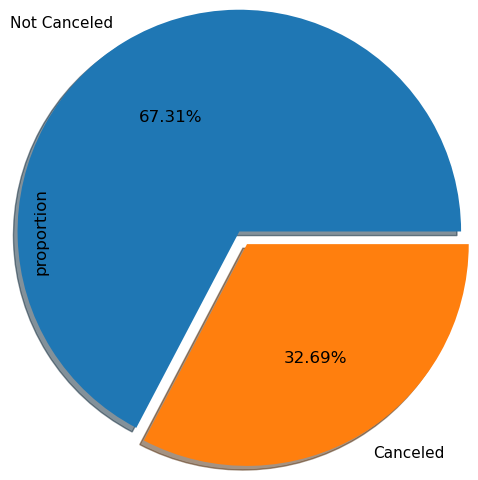

In [1122]:
past_data['booking_status'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f%%',radius=1.5,color=['Blue','Red'],shadow=True,explode=[0,0.1])
plt.show()

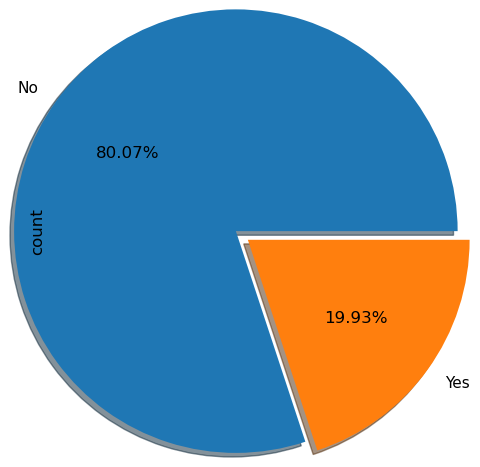

In [1123]:
# How many cancelled bookings were rebooked..
past_data.loc[past_data['booking_status'] == 'Canceled', 'rebooked'].value_counts().plot(kind='pie',autopct='%.2f%%',radius=1.5,color=['Blue','Red'],shadow=True,explode=[0,0.1])
plt.show()

#### Inference: Here we can see that out of all booking ~33% bookings are being cancelled and out of these 33% only ~20% bookings are rebooked. Hence, heuristic approach is not affective, the inventory losses are still very high?

## Exploring the data

In [1126]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [1127]:
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [1128]:
## Booking is a redundant column lets make it index..

past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [1129]:
# We also need to change the datatype of columns 'Arrival Date' to datetime
past_data['arrival_date'] = pd.to_datetime(past_data['arrival_date'],format='%Y-%m-%d')
new_data['arrival_date'] = pd.to_datetime(new_data['arrival_date'],format='%Y-%m-%d')

In [1130]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


### Univariate Analysis

In [1132]:
num_cols = ['lead_time','avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests', 'no_of_adults', 'no_of_weekend_nights', 
            'required_car_parking_space', 'no_of_week_nights','booking_status', 'rebooked']

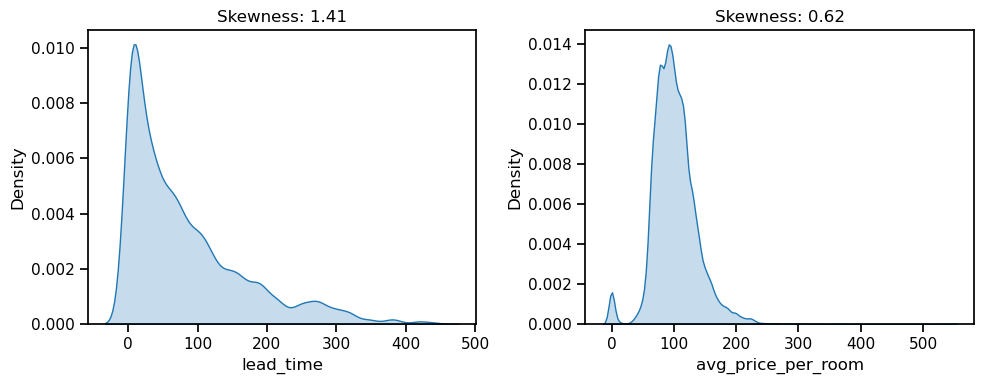

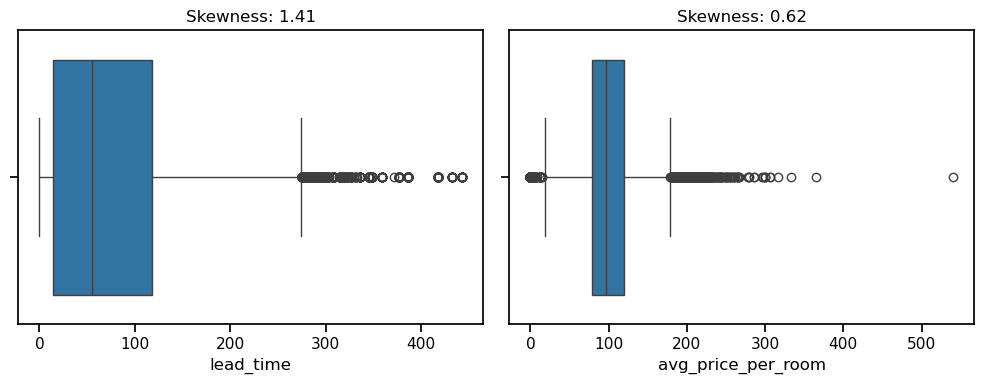

In [1133]:
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.kdeplot(past_data[i], fill=True)
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()

#### Inference: 
* The lead time has very large values > 200, which means there are bookings which have need made more than 200 days prior!!
* There are booking with averag eprice per room is 0?

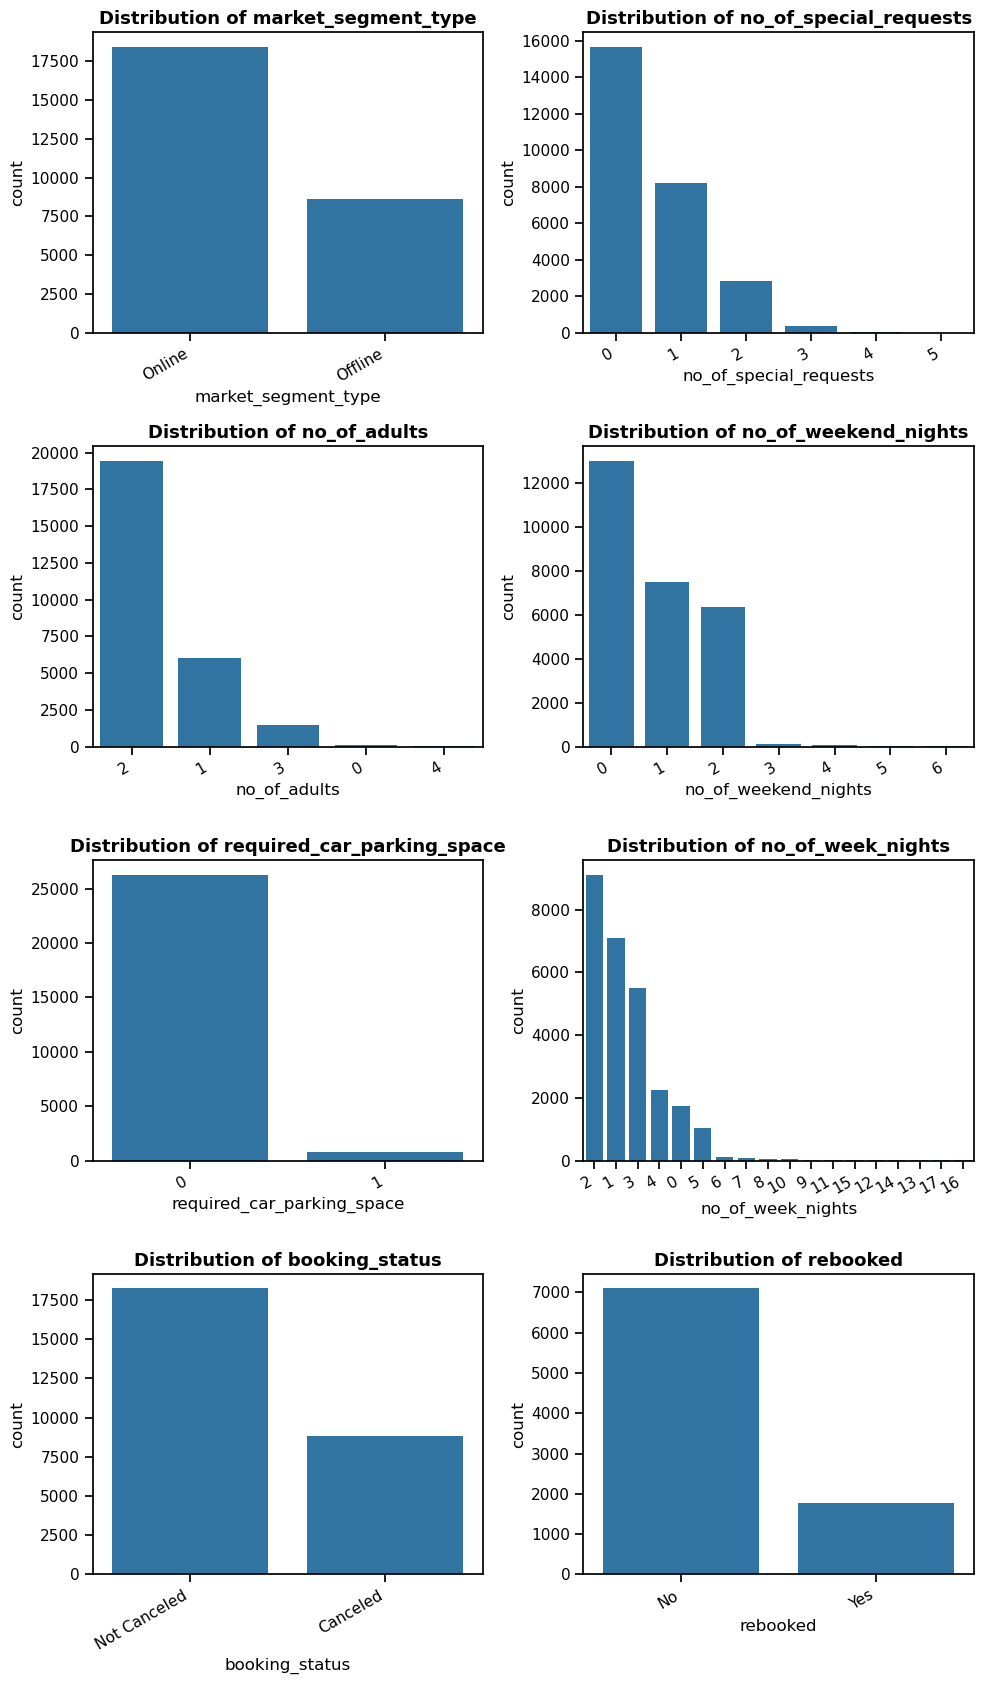

In [1135]:
plt.figure(figsize=(10, 17))
p = 1
for i in cat_cols:
    plt.subplot(4, 2, p)
    ax = sns.countplot(data=past_data, x=i, order=past_data[i].value_counts().index)
    plt.title(f'Distribution of {i}', fontsize=13, fontweight='bold')
    plt.xticks(rotation=30, ha='right')
    p += 1
plt.tight_layout()
plt.show()

## Bivariate analysis

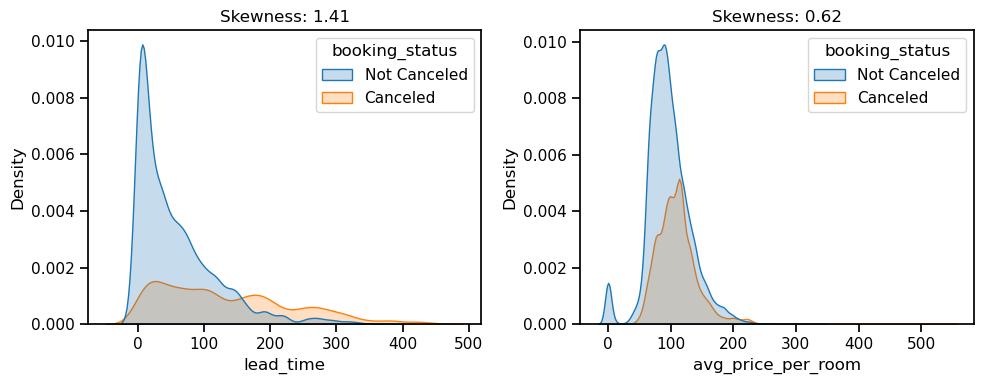

In [1137]:
sns.set(style=None, palette=None, font_scale=1)
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.kdeplot(data=past_data,x=i, fill=True, hue='booking_status')
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()

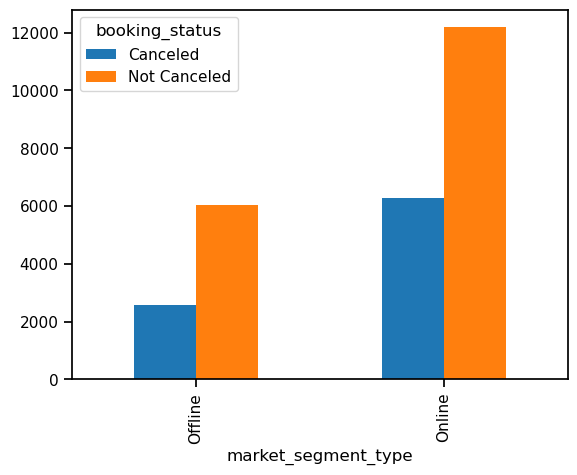

In [1138]:
# Cat vs Cat (Grouped Bar Plot)
pd.crosstab(past_data['market_segment_type'],past_data['booking_status']).plot(kind='bar')
plt.show()

<Figure size 1000x400 with 0 Axes>

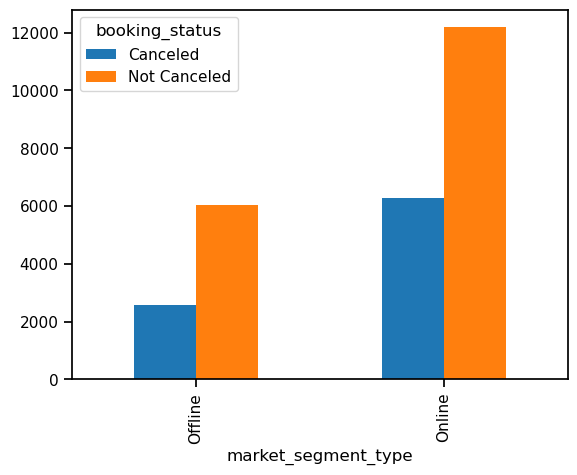

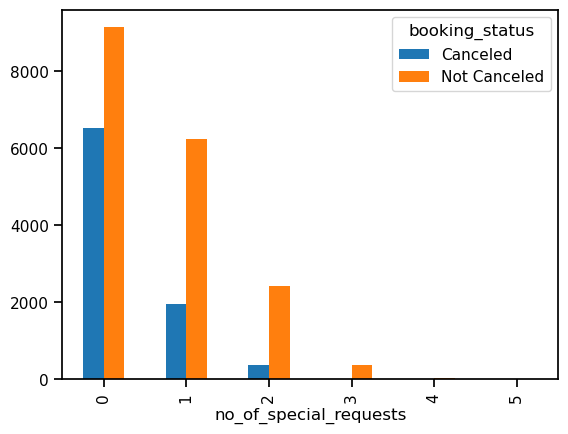

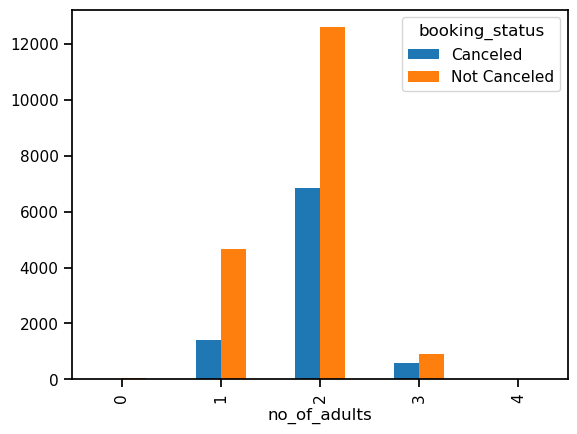

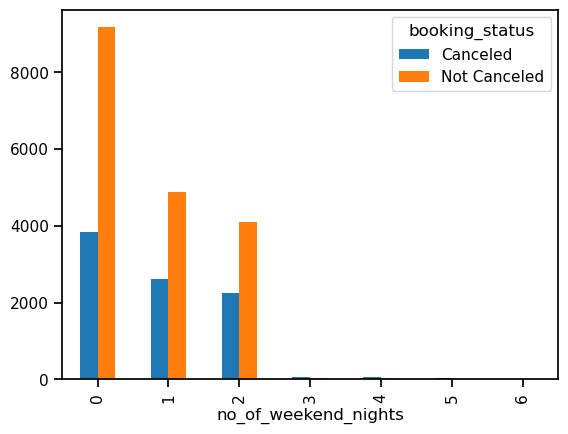

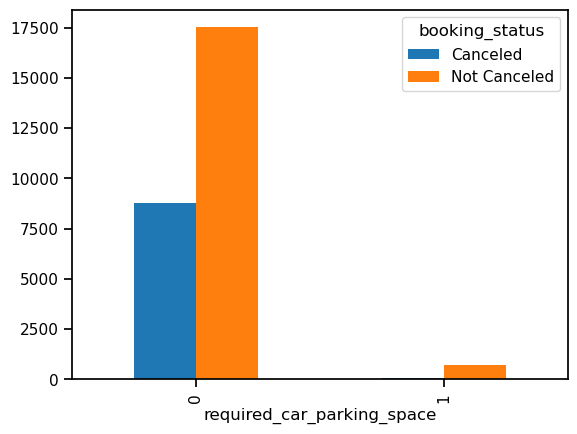

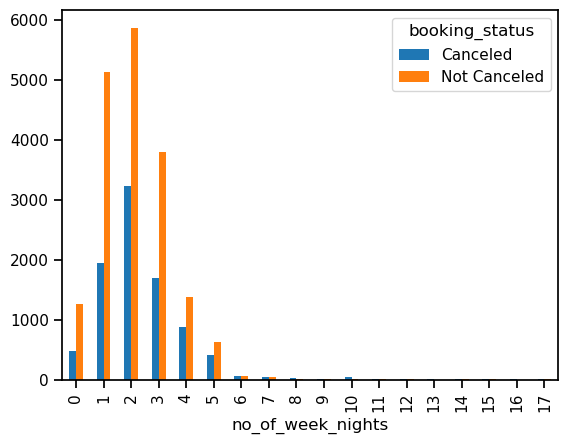

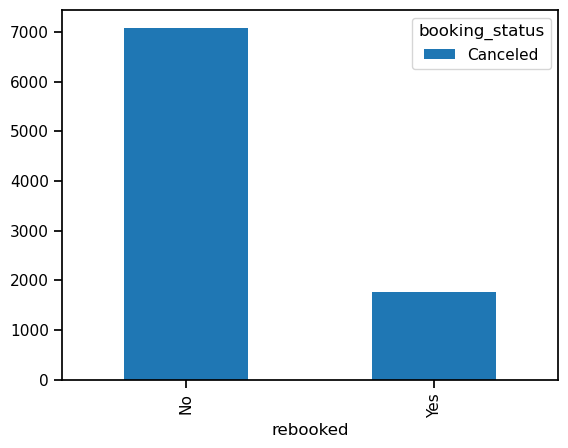

In [1139]:
plt.figure(figsize=[10,4])
for i in cat_cols:
    if i!='booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()
plt.show()

#### Inference:
*
*
*


## Multivariate Analysis

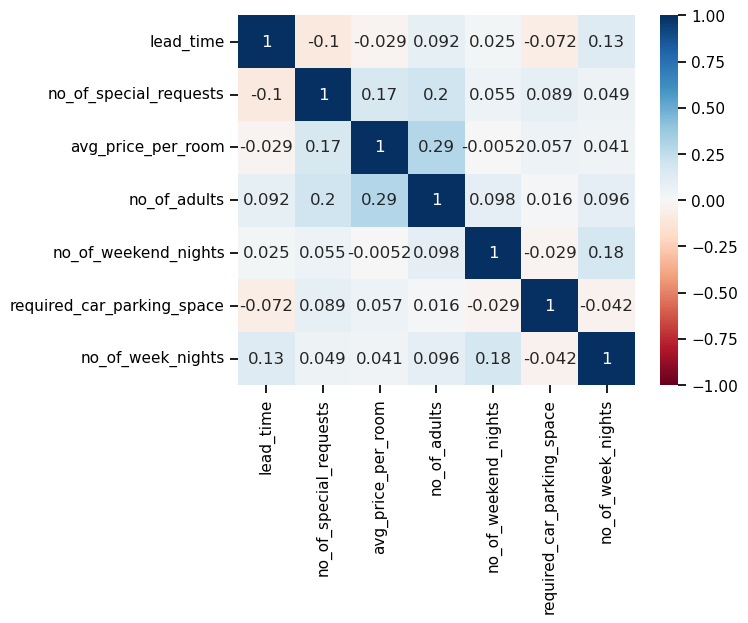

In [1142]:
sns.heatmap(past_data.corr(numeric_only=True),annot=True,cmap='RdBu',vmin=-1)
plt.show()

## Inferential Statistics

In [1144]:
# Let's statistically test the inferences that we have made..

In [1145]:
# Lead Time vs Booking Status
samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']

# Let's go with twi-sample t-test
# Ho: mu1=mu2 (Lead time does not affects the booking cancellations)
# Ha: mu1!=mu2 (Lead time does affects the booking cancellations)

# Assumption 1: Data must be normal (Since sample size>30, let's asusme it to be normal)


# Assumption 2: Variances must be equal (Levene Test)
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))    # pvalue=0.0
# Since, pvalue<0.05, we reject Ho.

# Hence, variances of population are not equal. Hence, lets go with two sample t-test with equal variances
print(stats.ttest_ind(samp1,samp2,equal_var=False))    # pvalue=0.0
# Since, pvalue<0.05, we reject Ho.

LeveneResult(statistic=3210.120590252021, pvalue=0.0)
TtestResult(statistic=66.84799194126163, pvalue=0.0, df=12138.394836237343)


In [1146]:
# Average Room Price vs Booking Status
samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']

# Let's go with twi-sample t-test
# Ho: mu1=mu2 (Average price per room does not affects the booking cancellations)
# Ha: mu1!=mu2 (Average price per room does affects the booking cancellations)

# Assumption 1: Data must be normal (Since sample size>30, let's asusme it to be normal)


# Assumption 2: Variances must be equal (Levene Test)
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))    # pvalue=6.490728476679038e-08
# Since, pvalue<0.05, we reject Ho.

# Hence, variances of population are not equal. Hence, lets go with two sample t-test with equal variances
print(stats.ttest_ind(samp1,samp2,equal_var=False))    # pvalue=8.462441935004689e-193
# Since, pvalue<0.05, we reject Ho.

LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)
TtestResult(statistic=29.9727805387597, pvalue=8.462441935004689e-193, df=18575.27155776574)


In [1147]:
# All category columns vs Booking Status

# chi-square test for independents
# It is non-parametric test, so no assumptions as such..

# Ho: No relation in categories
# Ha: There is relation in categories

for i in cat_cols:
    if i not in ['booking_status','rebooked']:
        ct = pd.crosstab(past_data['booking_status'],past_data[i])
        print(i,stats.chi2_contingency(ct)[1])

# market_segment_type 7.806389643886697e-11
# no_of_special_requests 0.0
# no_of_adults 1.441185511500568e-73
# no_of_weekend_nights 5.324997086476798e-43
# required_car_parking_space 5.626905783478662e-49
# no_of_week_nights 7.318602549508705e-65

# Since, pvalues for all the category columns are less than 0.05, all categorical columns are statistically significant

market_segment_type 7.806389643886697e-11
no_of_special_requests 0.0
no_of_adults 1.441185511500568e-73
no_of_weekend_nights 5.324997086476798e-43
required_car_parking_space 5.626905783478662e-49
no_of_week_nights 7.318602549508705e-65


## Data Preprocessing

In [1149]:
# Let's remove the 'rebooked' column from the predictive modelling as this info will not be available for future data..

In [1150]:
past_data.drop(columns='rebooked',inplace=True)

In [1151]:
past_data.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled


### Missing Values

In [1153]:
past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [1154]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

### Outlier Treatment

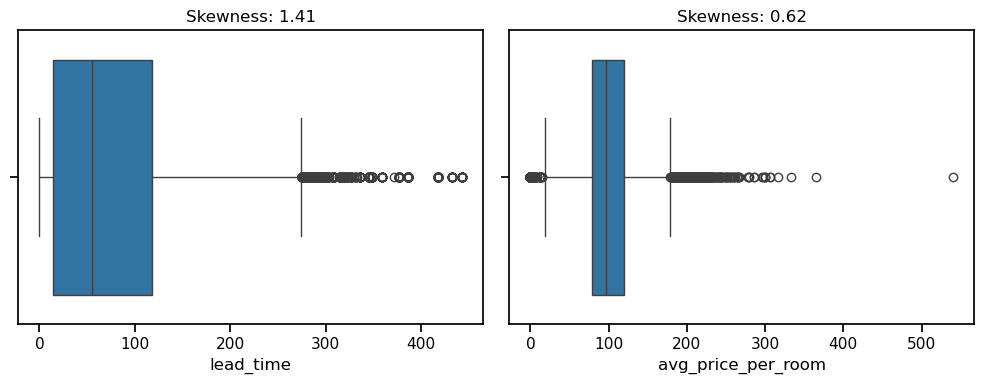

In [1156]:
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()

In [1157]:
# Let's cap the extreme outliers..
for i in num_cols:
    q1,q3 = np.quantile(past_data[i],[0.25,0.75])
    iqr = q3-q1
    ul,ll = q3+2.5*iqr, q1-2.5*iqr
    past_data[i] = past_data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

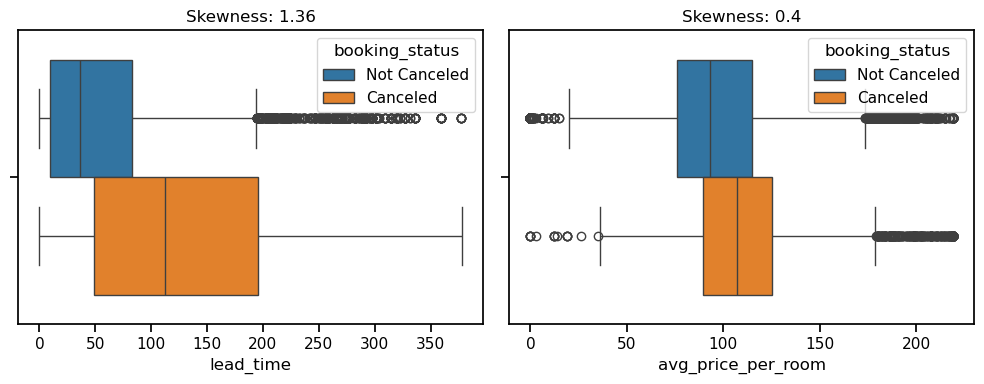

In [1158]:
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.boxplot(data=past_data,x=i,hue='booking_status')
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()

## Feature Encoding

In [1160]:
past_data.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0.0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34.0,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
INNHG_101036,24.0,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled
INNHG_101037,23.0,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled
INNHG_101038,46.0,Online,1,149.40,2,2,2021-01-01,0,3,Canceled


In [1161]:
past_data = pd.get_dummies(past_data,columns=['market_segment_type'],drop_first=True,dtype=int)
new_data = pd.get_dummies(new_data,columns=['market_segment_type'],drop_first=True,dtype=int)

In [1162]:
# Let's do ordinal encoding for booking status..
past_data['booking_status'] = past_data['booking_status'].map({'Canceled':1,'Not Canceled':0})
new_data['booking_status'] = new_data['booking_status'].map({'Canceled':1,'Not Canceled':0})

In [1163]:
past_data.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_101034,0.0,0,85.03,1,1,2021-01-01,0,0,0,1
INNHG_101035,34.0,2,125.10,2,2,2021-01-01,0,0,0,1
INNHG_101036,24.0,1,71.69,2,2,2021-01-01,0,0,0,1


## Feature Transformation

In [1165]:
transformer = PowerTransformer(standardize=False)

In [1166]:
past_data[num_cols] = transformer.fit_transform(past_data[num_cols])
new_data[num_cols] = transformer.transform(new_data[num_cols])

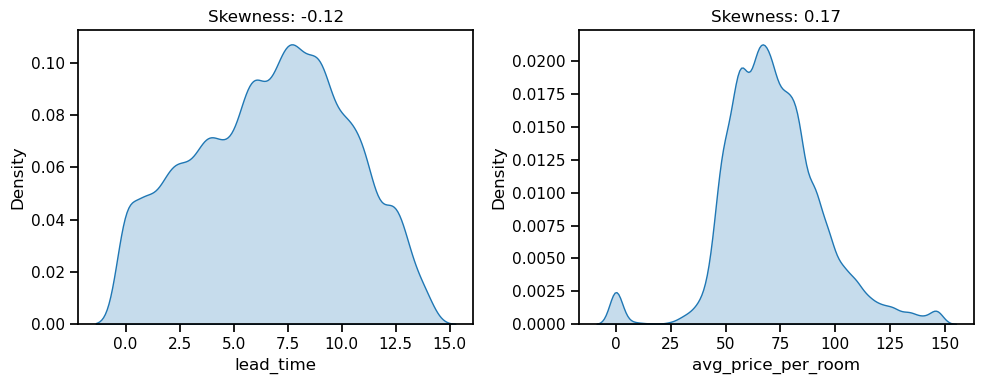

In [1167]:
sns.set(style=None, palette=None, font_scale=1)
plt.figure(figsize=[10,4])
p = 1
for i in num_cols:
    plt.subplot(1, 2, p)
    sns.kdeplot(data=past_data,x=i, fill=True)
    plt.title(f'Skewness: {np.round(past_data[i].skew(), 2)}')
    p += 1
plt.tight_layout()
plt.show()

## Feature Engineering (Generate New Columns)

In [1169]:
past_data.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,2021-01-01,0,0,0,1
INNHG_101035,5.784470,2,87.801167,2,2,2021-01-01,0,0,0,1
INNHG_101036,4.986923,1,52.818520,2,2,2021-01-01,0,0,0,1


In [1170]:
# Let's extrract month and weekday from date of arrival
past_data['arrival_month'] = past_data['arrival_date'].dt.month
past_data['arrival_wkday'] = past_data['arrival_date'].dt.weekday
past_data.drop(columns='arrival_date',inplace=True)

In [1171]:
past_data.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4


In [1172]:
new_data['arrival_month'] = new_data['arrival_date'].dt.month
new_data['arrival_wkday'] = new_data['arrival_date'].dt.weekday
new_data.drop(columns='arrival_date',inplace=True)

In [1173]:
new_data.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4
INNHG_128129,6.367294,1,88.952344,2,1,1,2,0,1,7,4


In [1174]:
# We can add no. of weekdays and weekdn in the booking and get the stay duration
past_data['total_nights'] = past_data['no_of_week_nights'] + past_data['no_of_weekend_nights']
new_data['total_nights'] = new_data['no_of_week_nights'] + new_data['no_of_weekend_nights']

In [1175]:
past_data.shape

(27093, 12)

In [1176]:
# We can also calculate departure weekday from total nights and arrival weekday..
past_data['depart_wkday'] = past_data['arrival_wkday']+past_data['total_nights']
new_data['depart_wkday'] = new_data['arrival_wkday']+new_data['total_nights']

In [1177]:
def setting_weekday(num):
    if num>6:
        return num%7
    else:
        return num

In [1178]:
past_data['depart_wkday'] = past_data['depart_wkday'].apply(setting_weekday)
new_data['depart_wkday'] = new_data['depart_wkday'].apply(setting_weekday)

In [1179]:
past_data.head(3)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4,1,5
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4,2,6
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4,2,6


In [1180]:
past_data.shape

(27093, 13)

In [1181]:
new_data.shape

(3583, 13)

# Predictive Modelling

In [1183]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.metrics import (roc_auc_score,roc_curve,classification_report,cohen_kappa_score,accuracy_score,recall_score,precision_score,f1_score,)

## Train-Test-Split

In [1185]:
y_train = past_data['booking_status']
x_train = past_data.drop(columns='booking_status')
y_test = new_data['booking_status']
x_test = new_data.drop(columns='booking_status')

In [1186]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(27093, 12) (27093,)
(3583, 12) (3583,)


## Modular Coding (Creating Functions for tasks)

In [1188]:
def model_train(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]

    return m,pred_h,pred_s

In [1189]:
def model_score(predh,preds,ytest=y_test):
    print('Classification Report')
    print(classification_report(ytest,predh))

    fpr,tpr,thres = roc_curve(ytest,preds)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],color='Red',ls='--')
    plt.title(f'ROC AUC {round(roc_auc_score(ytest,preds),4)}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [1190]:
def model_name(model):
    l1=str(model).split('(')
    return l1[0]
def model_tuning(model,grid,x=x_train,y=y_train,folds=6,score='roc_auc'):

    gscv = GridSearchCV(estimator=model,param_grid=grid,scoring=score,cv=folds,verbose=1,n_jobs=5)
    gscv.fit(x,y)
    print('Best Score', gscv.best_score_)
    return gscv.best_params_

In [1191]:
mod = []
accu = []
rec = []
prec = []
f1 = []
ck = []
auc = []

In [1192]:
def model_scorecard(model,predh,preds,ytest=y_test):
    mod.append(model_name(model))
    accu.append(accuracy_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    prec.append(precision_score(ytest,predh))
    f1.append(f1_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))

    scorecard = pd.DataFrame({'Accuracy':accu,'Precision':prec,'Recall':rec,'F1':f1,'Cohen Kappa':ck,'ROC AUC':auc},index=mod)
    return scorecard

In [1193]:
model_lr,predh_lr,preds_lr = model_train(LogisticRegression(class_weight='balanced'),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      2383
           1       0.56      0.78      0.65      1200

    accuracy                           0.72      3583
   macro avg       0.71      0.73      0.71      3583
weighted avg       0.76      0.72      0.73      3583



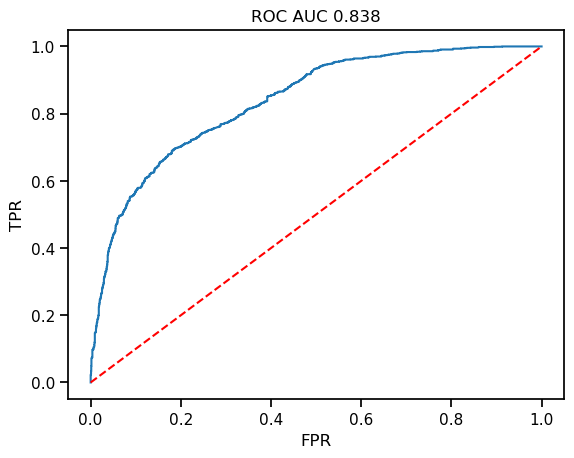

In [1194]:
model_score(predh_lr,preds_lr)

In [1195]:
model_scorecard(model_lr,predh_lr,preds_lr,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775,0.650577,0.428409,0.837961


## Naive Bayes

In [1197]:
model_gnb,predh_gnb,preds_gnb = model_train(GaussianNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2383
           1       0.56      0.61      0.58      1200

    accuracy                           0.71      3583
   macro avg       0.68      0.68      0.68      3583
weighted avg       0.71      0.71      0.71      3583



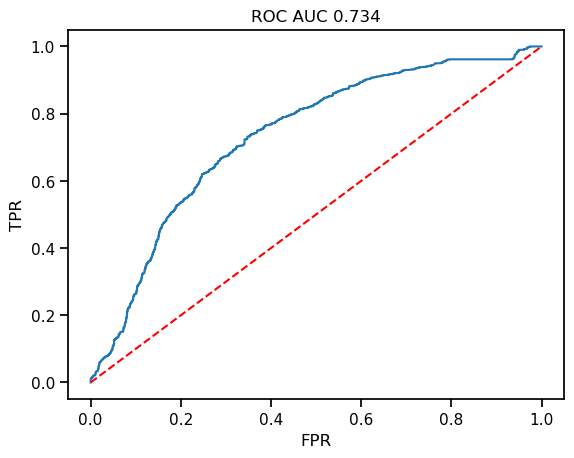

In [1198]:
model_score(predh_gnb, preds_gnb)

In [1199]:
model_scorecard(model_gnb,predh_gnb,preds_gnb,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


In [1200]:
model_mnb,predh_mnb,preds_mnb = model_train(MultinomialNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      2383
           1       0.72      0.14      0.23      1200

    accuracy                           0.69      3583
   macro avg       0.71      0.56      0.52      3583
weighted avg       0.70      0.69      0.62      3583



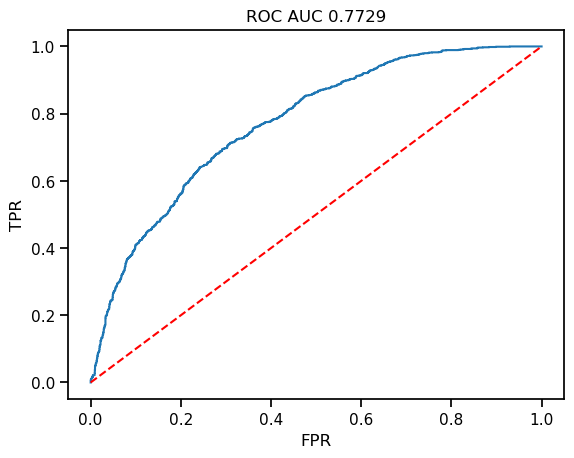

In [1201]:
model_score(predh_mnb, preds_mnb)

In [1202]:
model_scorecard(model_mnb,predh_mnb,preds_mnb,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855


## Decision Tree

In [1204]:
#tuned_params = model_tuning(DecisionTreeClassifier(class_weight='balanced'),{'max_depth':[7,9,11,13,15],'max_leaf_nodes':[23,24,25,26,27]})

In [1205]:
tuned_params = {'max_depth': 9, 'max_leaf_nodes': 26}

In [1206]:
model_dt,predh_dt,preds_dt = model_train(DecisionTreeClassifier(class_weight='balanced',**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2383
           1       0.65      0.73      0.69      1200

    accuracy                           0.78      3583
   macro avg       0.75      0.77      0.76      3583
weighted avg       0.79      0.78      0.78      3583



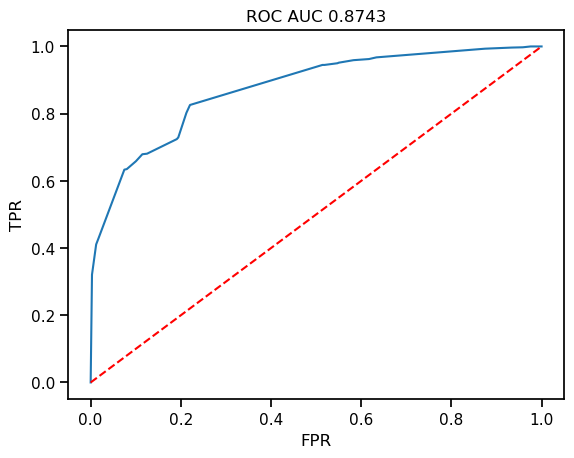

In [1207]:
model_score(predh_dt, preds_dt)

In [1208]:
model_scorecard(model_dt,predh_dt,preds_dt,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321


## Random Forest

In [1210]:
#tuned_params = model_tuning(RandomForestClassifier(max_features=None,class_weight='balanced'),grid={'max_depth':[5,6,7],'n_estimators':[45,50,55]})

In [1211]:
tuned_params = {'max_depth': 5, 'n_estimators': 55}

In [1212]:
model_rf,predh_rf,preds_rf = model_train(RandomForestClassifier(max_features=None,class_weight='balanced',**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2383
           1       0.68      0.80      0.73      1200

    accuracy                           0.81      3583
   macro avg       0.78      0.80      0.79      3583
weighted avg       0.82      0.81      0.81      3583



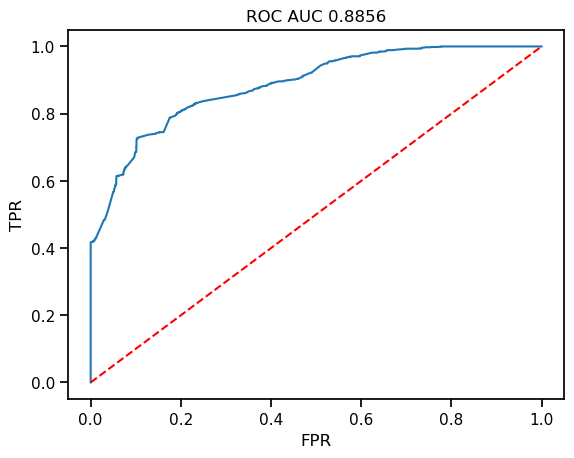

In [1213]:
model_score(predh_rf, preds_rf)

In [1214]:
model_scorecard(model_rf,predh_rf,preds_rf,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609


## AdaBoost

In [1216]:
# model_tuning(AdaBoostClassifier(random_state=2), grid={'n_estimators':[50,70,100,120,150],'learning_rate':[0.01,0.1,1]})

In [1217]:
tuned_params = {'learning_rate': 0.1, 'n_estimators': 200}

In [1218]:
model_ada,predh_ada,preds_ada = model_train(AdaBoostClassifier(random_state=2,**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2383
           1       0.72      0.62      0.67      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.75      0.76      3583
weighted avg       0.79      0.79      0.79      3583



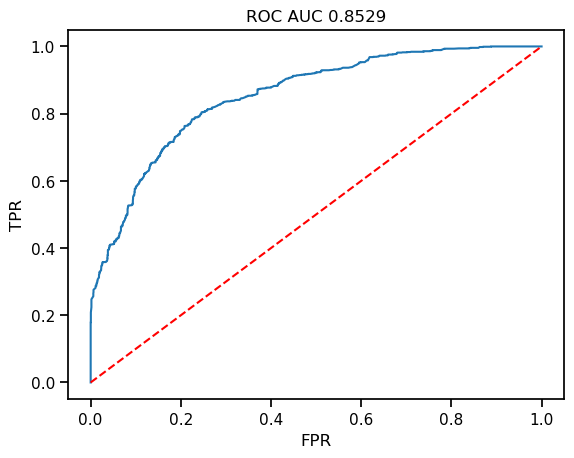

In [1219]:
model_score(predh_ada,preds_ada)

In [1220]:
model_scorecard(model_ada,predh_ada,preds_ada,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928


## Gradient Boost

In [1222]:
# tuned_params = model_tuning(GradientBoostingClassifier(random_state=2), grid={'n_estimators':[50,100,150],'learning_rate':[0.01,0.1,1],'max_depth':[5,7,9]})

In [1223]:
tuned_params = {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 90}

In [1224]:
model_gbm,predh_gbm,preds_gbm = model_train(GradientBoostingClassifier(random_state=2,**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2383
           1       0.86      0.59      0.70      1200

    accuracy                           0.83      3583
   macro avg       0.84      0.77      0.79      3583
weighted avg       0.83      0.83      0.82      3583



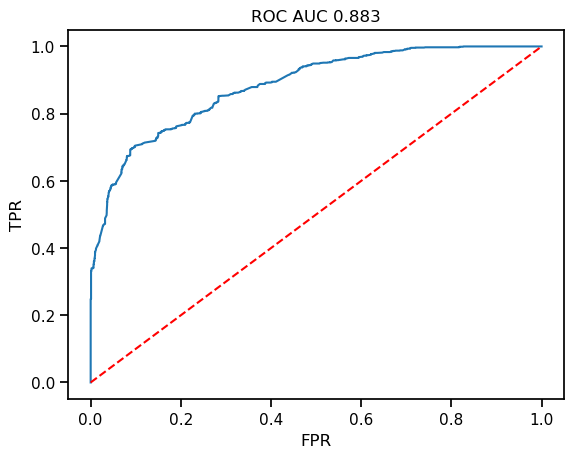

In [1225]:
model_score(predh_gbm,preds_gbm)

In [1226]:
model_scorecard(model_gbm,predh_gbm,preds_gbm,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928
GradientBoostingClassifier,0.829473,0.857837,0.588333,0.697973,0.584842,0.882960


## XGBoost

In [1228]:
# tuned_params = model_tuning(XGBClassifier(), grid={'n_estimators':[40,50,60,70],'learning_rate':[0.01,0.1],'max_depth':[5,6,7,8,10]})

In [1229]:
tuned_params = {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}

In [1230]:
model_xgb,predh_xgb,preds_xgb = model_train(XGBClassifier(**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2383
           1       0.84      0.64      0.73      1200

    accuracy                           0.84      3583
   macro avg       0.84      0.79      0.81      3583
weighted avg       0.84      0.84      0.83      3583



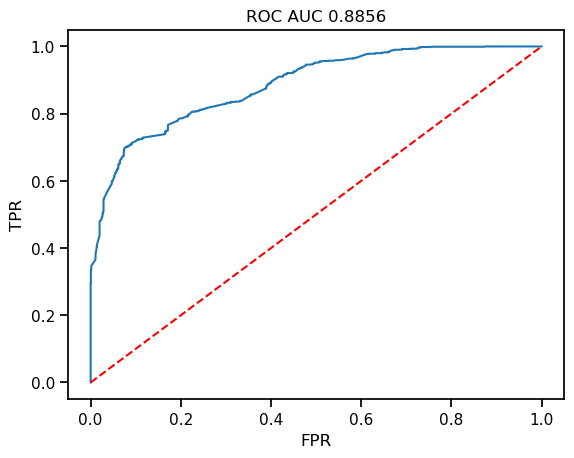

In [1231]:
model_score(predh_xgb,preds_xgb)

In [1232]:
model_scorecard(model_xgb,predh_xgb,preds_xgb,y_test)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928
GradientBoostingClassifier,0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
XGBClassifier,0.838404,0.841584,0.637500,0.725462,0.614032,0.885587


# Voting

In [1234]:
base_estimators = [('RF',model_rf),('GBM',model_gbm),('XGB',model_xgb),('DT',model_dt)]

In [1235]:
model_vot = VotingClassifier(estimators=base_estimators,voting='soft')

In [1236]:
model_vot.fit(x_train,y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_features=None,
                                                     n_estimators=55)),
                             ('GBM',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=7,
                                                         n_estimators=90,
                                                         random_state=2)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_by...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('DT',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=9,
                                                     max_leaf_nodes=26))],
                 voting='soft')

In [1237]:
predh_vot = model_vot.predict(x_test)
preds_vot = model_vot.predict_proba(x_test)[:,1]

In [1238]:
model_vot.predict_proba(x_test)[:,1]

array([0.10847984, 0.25918056, 0.25836201, ..., 0.77554916, 0.84184207,
       0.60221734])

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2383
           1       0.79      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.81      0.82      3583
weighted avg       0.84      0.84      0.84      3583



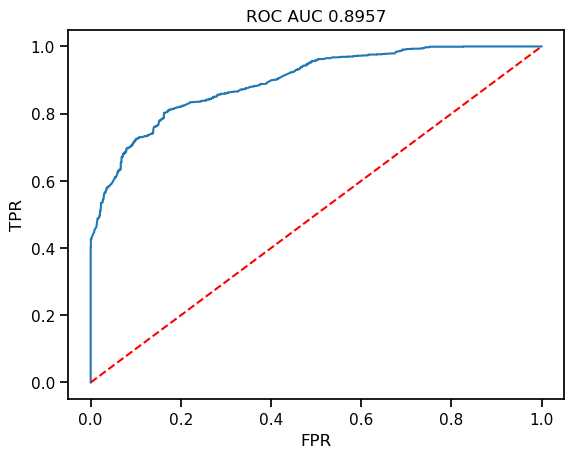

In [1239]:
model_score(predh_vot,preds_vot)

In [1240]:
scorecard = model_scorecard(model_vot,predh_vot,preds_vot,y_test)

In [1241]:
scorecard.sort_values(by='ROC AUC',ascending=False)

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
VotingClassifier,0.840357,0.792910,0.708333,0.748239,0.631904,0.895669
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
XGBClassifier,0.838404,0.841584,0.637500,0.725462,0.614032,0.885587
GradientBoostingClassifier,0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


## Stacking

In [1243]:
model_stack = StackingClassifier(cv=6,estimators=base_estimators)

In [1244]:
model_stack.fit(x_train,y_train)

StackingClassifier(cv=6,
                   estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features=None,
                                                       n_estimators=55)),
                               ('GBM',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=7,
                                                           n_estimators=90,
                                                           random_state=2)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsa...
                                              learning_rate=0.01, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('DT',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=9,
                                                       max_leaf_nodes=26))])

In [1245]:
predh_stack = model_stack.predict(x_test)
preds_stack = model_stack.predict_proba(x_test)[:,1]

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2383
           1       0.80      0.64      0.71      1200

    accuracy                           0.82      3583
   macro avg       0.82      0.78      0.79      3583
weighted avg       0.82      0.82      0.82      3583



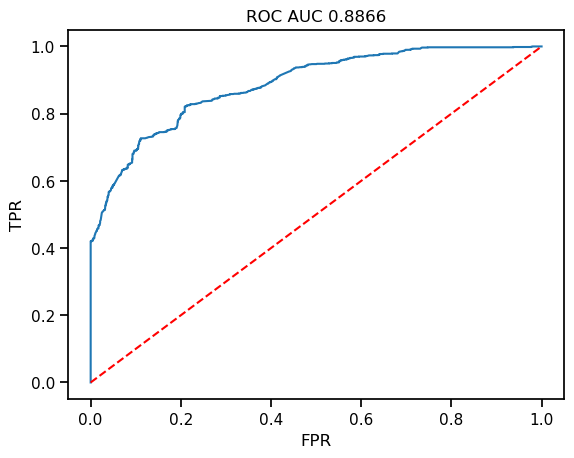

In [1246]:
model_score(predh_stack,preds_stack)

In [1247]:
scorecard = model_scorecard(model_stack,predh_stack,preds_stack,y_test).sort_values(by='ROC AUC',ascending=False)

In [1248]:
scorecard

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
VotingClassifier,0.840357,0.792910,0.708333,0.748239,0.631904,0.895669
StackingClassifier,0.824170,0.796875,0.637500,0.708333,0.584697,0.886554
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
XGBClassifier,0.838404,0.841584,0.637500,0.725462,0.614032,0.885587
GradientBoostingClassifier,0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


# Final Model

In [1250]:
scorecard

,Accuracy,Precision,Recall,F1,Cohen Kappa,ROC AUC
VotingClassifier,0.840357,0.792910,0.708333,0.748239,0.631904,0.895669
StackingClassifier,0.824170,0.796875,0.637500,0.708333,0.584697,0.886554
RandomForestClassifier,0.805470,0.678242,0.797500,0.733052,0.581600,0.885609
XGBClassifier,0.838404,0.841584,0.637500,0.725462,0.614032,0.885587
GradientBoostingClassifier,0.829473,0.857837,0.588333,0.697973,0.584842,0.882960
DecisionTreeClassifier,0.780073,0.653961,0.729167,0.689519,0.520030,0.874321
AdaBoostClassifier,0.793190,0.721311,0.623333,0.668753,0.519576,0.852928
LogisticRegression,0.721183,0.560579,0.775000,0.650577,0.428409,0.837961
MultinomialNB,0.693832,0.724891,0.138333,0.232330,0.140019,0.772855
GaussianNB,0.706391,0.556061,0.611667,0.582540,0.356899,0.734001


In [1251]:
# We choose Voting as our final model as it has best roc auc.
# Now we will check for overfitting
# We will also have to improve the scores in 1 by changing cut-off classifier..

In [1252]:
scores = cross_val_score(estimator=model_vot,cv=KFold(n_splits=7,shuffle=True,random_state=2),
                        scoring='roc_auc',X=x_train,y=y_train,n_jobs=5,verbose=1)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:   24.0s finished


In [1253]:
scores

array([0.90581914, 0.90562491, 0.90584366, 0.90306047, 0.91429655,
       0.92138739, 0.90740961])

In [1254]:
# So, from scores, we can say that the variance is controlled..

## Adjusting cut-off classifier..

In [1256]:
fpr,tpr,thres = roc_curve(y_test,preds_vot)

In [1257]:
pd.DataFrame({'FPR':fpr,'TPR':tpr,'THRESHOLD':thres,"Yoden's Index":tpr*(1-fpr)}).sort_values(by="Yoden's Index", ascending=False)

,FPR,TPR,THRESHOLD,Yoden's Index
415,0.162400,0.802500,0.422047,0.672174
416,0.163659,0.802500,0.421980,0.671163
432,0.173311,0.811667,0.410528,0.670996
417,0.164079,0.802500,0.421434,0.670827
414,0.162400,0.800833,0.422102,0.670778
...,...,...,...,...
1016,0.997482,1.000000,0.074413,0.002518
1,0.000000,0.002500,0.858974,0.002500
1017,0.998741,1.000000,0.073932,0.001259
0,0.000000,0.000000,inf,0.000000


In [1378]:
predh_vot_adj = (preds_vot>0.422047).astype(int)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2383
           1       0.71      0.80      0.75      1200

    accuracy                           0.83      3583
   macro avg       0.80      0.82      0.81      3583
weighted avg       0.83      0.83      0.83      3583



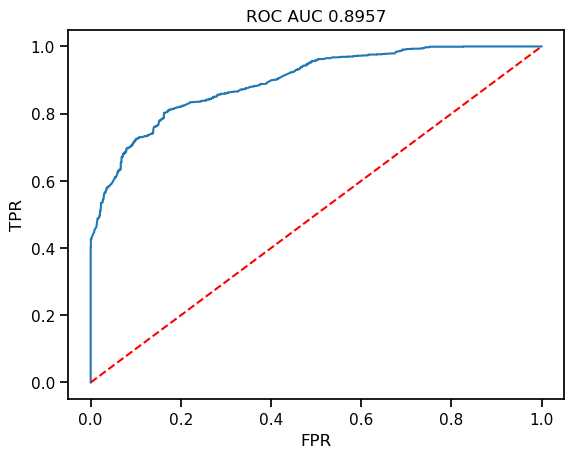

In [1380]:
model_score(predh_vot_adj,preds_vot)

## Deployment

In [1383]:
x_test.columns

Index(['lead_time', 'no_of_special_requests', 'avg_price_per_room',
       'no_of_adults', 'no_of_weekend_nights', 'required_car_parking_space',
       'no_of_week_nights', 'market_segment_type_Online', 'arrival_month',
       'arrival_wkday', 'total_nights', 'depart_wkday'],
      dtype='object')

In [1385]:
lt = 10
spcl = 0
price = 120
nad = 2
wend = 2
park = 0
week = 1
mark = 1
arv = 5
arvw = 4
tot = 3
depw = 0

In [1387]:
lt_t,price_t = transformer.transform([[lt,price]])[0]

In [1389]:
lt_t

3.305097485848945

In [1391]:
price_t

84.53117877205352

In [1407]:
model_vot.predict_proba([[lt_t,spcl,price_t,nad,wend,park,week,mark,arv,arvw,tot,depw]])[0][1]   # Prob. of 1

0.5855393684877537

In [1397]:
import sklearn
sklearn.__version__

'1.5.1'

In [1401]:
# Let's create some files that we need for deployment..
import pickle

In [1403]:
with open('final_model.pkl','wb') as file:
    pickle.dump(model_vot,file)

In [1405]:
with open('transformer.pkl','wb') as file:
    pickle.dump(transformer,file)

In [1409]:
x_train.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,1,1,4,1,5
INNHG_101035,5.784470,2,87.801167,2,2,0,0,1,1,4,2,6
INNHG_101036,4.986923,1,52.818520,2,2,0,0,1,1,4,2,6
INNHG_101037,4.894729,0,61.510571,1,2,0,0,1,1,4,2,6
INNHG_101038,6.541683,1,103.222808,2,2,0,3,1,1,4,5,2


In [1411]:
import xgboost
xgboost.__version__

'3.0.1'

In [1413]:
import pickle
pickle.__version__

AttributeError: module 'pickle' has no attribute '__version__'